In [1]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

#The path where i can find the X.npy file
Location = '/home/user-sl/Documents/metaptyxiako/Machine_Learning/Exc3/data-20210517T115459Z-001/data/X.npy'
data_X=np.load(Location)
print(data_X.shape)
print(data_X)

(3000, 2)
[[ 4.93793077 -2.62150417]
 [-1.73728355  6.0474439 ]
 [ 1.40865625 -2.33207308]
 ...
 [-6.63775626 -5.38217455]
 [ 1.21503104  0.45673594]
 [-7.64534674 -5.12399001]]


In [4]:
# The path where I can find the y.npy file
# I didn't used in any way this file
Location = '/home/user-sl/Documents/metaptyxiako/Machine_Learning/Exc3/data-20210517T115459Z-001/data/y.npy'
data_y=np.load(Location)
print(data_y.shape)
print(data_y)

(3000,)
[4 2 8 ... 6 8 6]


In [25]:
import random
from collections import defaultdict
import sys

# A function that helped me keep track of the centroids in the k-means++
def plot(data, centroids):
    plt.scatter(data[:, 0], data[:, 1], marker = '.', 
                color = 'gray', label = 'data points')
    plt.scatter(centroids[:-1, 0], centroids[:-1, 1],color = 'black', label = 'previously selected centroids')
    plt.scatter(centroids[-1, 0], centroids[-1, 1],color = 'red', label = 'next centroid')
    plt.title('Select % d th centroid'%(centroids.shape[0]))
      
    # plt.legend()
    plt.show()    


class k_means_model:
  # The init function constructor of the k-means model takes the parameters below and creates the first sets of centroids
  def __init__(self,data, k, init_method="random"):
    self.k = k
    # a list that keeps for all the point the centroid that they belong
    self.belong_centroids = []
    # a dictionary that keeps the position of all the centroids
    self.centroids={}
    self.data=data
    # A dictionary that has as keys the centroids and as values the points that belong to it
    self.classifications=defaultdict(list)
    # a list that helps the plot function implementation. 
    
    temp_c=[]
    if init_method=="random":
      for i in data:
        c=random.randint(1,self.k)
        self.belong_centroids.append(c)
        self.classifications[c].append(i)
      self.centroids_calculate()  
    elif init_method=="k_means++":
      self.centroids[1]=data[np.random.randint(data.shape[0]), :]
      temp_c.append(self.centroids[1])
      for c_id in range(2,k+1):
        dist = []
        for i in range(data.shape[0]):
            point = data[i, :]
            temp_dist=[]
            # compute distance of 'point' from each of the 
            # centroid and store the minimum distance (to the closer centroid)
            for j in self.centroids.keys():
                temp_dist.append(np.linalg.norm(point-self.centroids[j]))
            dist.append(min(temp_dist))
              
        # The selection of the next centroid will be one that is far from the others centroids.
        # The choice of the next centroid is weighted based on the distance. More the distance->more the possibility to be picked
        dist_arr = np.array([x**2 for x in dist])
        next_centroid = random.choices(data, weights=dist_arr)[0]
        self.centroids[c_id]=next_centroid
        temp_c.append(next_centroid)
        #If you want to run the plot functions to see how centroids are picked uncomment the line below.
        #plot(self.data,np.array(temp_c))

# a function that recognise the centroids based on the classification dictionary
  def centroids_calculate(self):
    for classification in self.classifications.keys():
      self.centroids[classification] = np.average(self.classifications[classification],axis=0) 

# a function that calculate the objective value
  def obj_function(self):
    sum=0
    for k,v in self.classifications.items():
      points=np.array(v)
      dist=[]
      sum_dims=0
      for p in points:
        sum_dims+=np.linalg.norm(self.centroids[k]-p)**2
      sum+=sum_dims/len(v)
    return sum  

  # a function that categories the points to the centroids they belong
  def classification_to_centroids(self,data):
    self.prev_belong_centroids=self.belong_centroids
    self.belong_centroids = []
    self.classifications=defaultdict(list)
    for i in data:
      distances={}
      for k,v in self.centroids.items():
        distances[k]=np.linalg.norm(i-v)
      centroid_key=min(distances, key=distances.get)
      self.belong_centroids.append(centroid_key)
      self.classifications[centroid_key].append(i)

  # fit the model and replace the centroids until our points won't change cluster 
  def fit(self,data,num_restarts=1):
    self.classification_to_centroids(data)
    A=np.array(self.prev_belong_centroids)
    B=np.array(self.belong_centroids)
    while A.shape!=B.shape or not((A==B).all()):
      self.centroids_calculate()
      self.classification_to_centroids(data)
      ####################
      # a plot to see how the centroids are rearranged
      # print("My Centroids:")
      # print(self.centroids)
      # for i in self.classifications.keys():
      #   points=np.array(self.classifications[i])
      #   # print(points)
      #   plt.scatter(points[:,0], points[:,1],s=10)

      # for i,v in self.centroids.items():
      #   plt.scatter(v[0], v[1], c='black', s=100, alpha=0.5);  
      # plt.show()
      ####################
      A=np.array(self.prev_belong_centroids)
      B=np.array(self.belong_centroids)
       
  

In [26]:
# This class was made to include the restart functionality. This function creates many k-means models and keep
# the values of the one with the best performance (objective value)
class k_means:
  def obj_function(self):
    sum=0
    for k,v in self.classifications.items():
      points=np.array(v)
      dist=[]
      sum_dims=0
      for p in points:
        sum_dims+=np.linalg.norm(self.centroids[k]-p)**2
      sum+=sum_dims/len(v)
    return sum  

  def fit_best_model(self,data,k,num_restarts=1, init_method="random"):
    min=sys.maxsize
    for i in range(num_restarts):
      model = k_means_model(data,k,init_method)
      # print(model.centroids)
      model.fit(data,num_restarts)
      # print(model.centroids)
      if model.obj_function()<min:
        min=model.obj_function()
        self.centroids=model.centroids
        self.classifications=model.classifications
        self.belong_centroids=model.belong_centroids 

  # a prediction function that will predict where a new point belongs
  def predict(self,data):
    classification=defaultdict(list)
    belong_centroids = []
    for i in data:
      distances={}
      for k,v in self.centroids.items():
        distances[k]=np.linalg.norm(i-v)
      centroid_key=min(distances, key=distances.get)
      belong_centroids.append(centroid_key)
      classification[centroid_key].append(i)
    return belong_centroids,classification        

[[ 1.89833024 -1.01073927]
 [-7.40372445  8.94342954]]
[1.89833024]


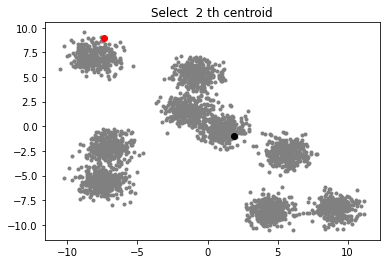

[[ 1.89833024 -1.01073927]
 [-7.40372445  8.94342954]
 [-7.07552516 -6.13971201]]
[ 1.89833024 -7.40372445]


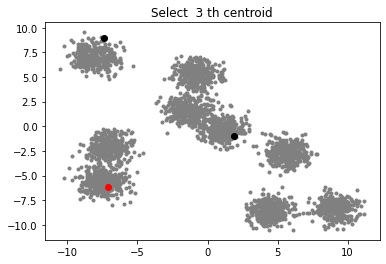

[[ 1.89833024 -1.01073927]
 [-7.40372445  8.94342954]
 [-7.07552516 -6.13971201]
 [ 4.27605921 -8.85889774]]
[ 1.89833024 -7.40372445 -7.07552516]


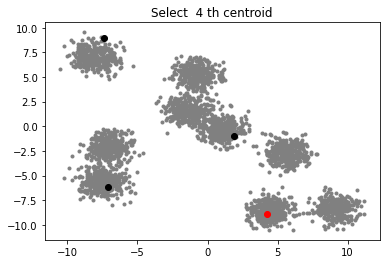

[[ 1.89833024 -1.01073927]
 [-7.40372445  8.94342954]
 [-7.07552516 -6.13971201]
 [ 4.27605921 -8.85889774]
 [ 9.96793022 -7.04240629]]
[ 1.89833024 -7.40372445 -7.07552516  4.27605921]


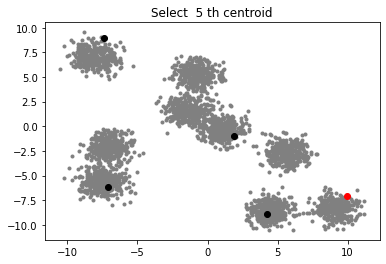

[[ 1.89833024 -1.01073927]
 [-7.40372445  8.94342954]
 [-7.07552516 -6.13971201]
 [ 4.27605921 -8.85889774]
 [ 9.96793022 -7.04240629]
 [ 4.78034703 -2.63975691]]
[ 1.89833024 -7.40372445 -7.07552516  4.27605921  9.96793022]


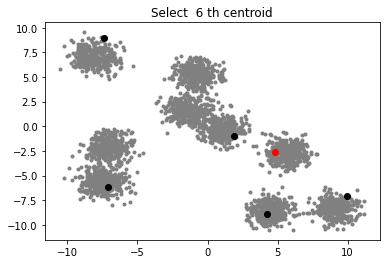

[[ 1.89833024 -1.01073927]
 [-7.40372445  8.94342954]
 [-7.07552516 -6.13971201]
 [ 4.27605921 -8.85889774]
 [ 9.96793022 -7.04240629]
 [ 4.78034703 -2.63975691]
 [-1.13009001  4.79974205]]
[ 1.89833024 -7.40372445 -7.07552516  4.27605921  9.96793022  4.78034703]


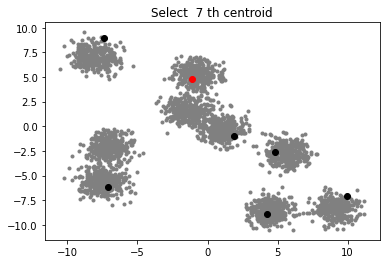

[[ 1.89833024 -1.01073927]
 [-7.40372445  8.94342954]
 [-7.07552516 -6.13971201]
 [ 4.27605921 -8.85889774]
 [ 9.96793022 -7.04240629]
 [ 4.78034703 -2.63975691]
 [-1.13009001  4.79974205]
 [ 8.22444399 -8.7106406 ]]
[ 1.89833024 -7.40372445 -7.07552516  4.27605921  9.96793022  4.78034703
 -1.13009001]


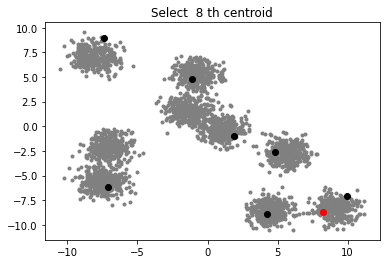

[[ 1.89833024 -1.01073927]
 [-7.40372445  8.94342954]
 [-7.07552516 -6.13971201]
 [ 4.27605921 -8.85889774]
 [ 9.96793022 -7.04240629]
 [ 4.78034703 -2.63975691]
 [-1.13009001  4.79974205]
 [ 8.22444399 -8.7106406 ]
 [-8.10842735  5.55123061]]
[ 1.89833024 -7.40372445 -7.07552516  4.27605921  9.96793022  4.78034703
 -1.13009001  8.22444399]


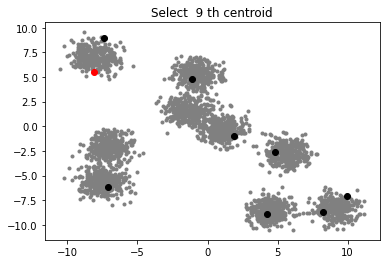

[[-5.83325875 -2.07737457]
 [-0.60896504  6.57164443]]
[-5.83325875]


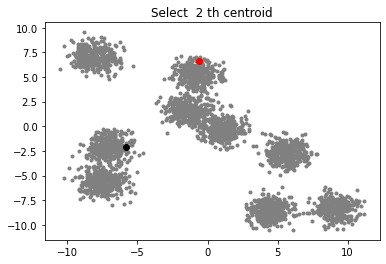

[[-5.83325875 -2.07737457]
 [-0.60896504  6.57164443]
 [-8.6908509   7.24245851]]
[-5.83325875 -0.60896504]


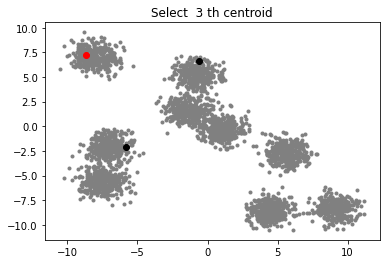

[[-5.83325875 -2.07737457]
 [-0.60896504  6.57164443]
 [-8.6908509   7.24245851]
 [10.26074638 -9.11506299]]
[-5.83325875 -0.60896504 -8.6908509 ]


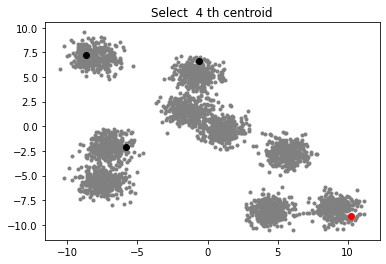

[[-5.83325875 -2.07737457]
 [-0.60896504  6.57164443]
 [-8.6908509   7.24245851]
 [10.26074638 -9.11506299]
 [ 0.23342677  1.70848921]]
[-5.83325875 -0.60896504 -8.6908509  10.26074638]


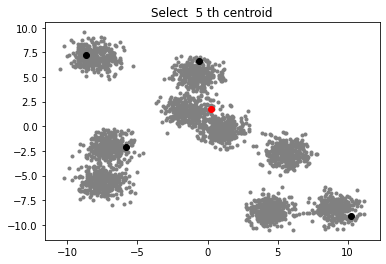

[[-5.83325875 -2.07737457]
 [-0.60896504  6.57164443]
 [-8.6908509   7.24245851]
 [10.26074638 -9.11506299]
 [ 0.23342677  1.70848921]
 [ 8.61719807 -8.92021946]]
[-5.83325875 -0.60896504 -8.6908509  10.26074638  0.23342677]


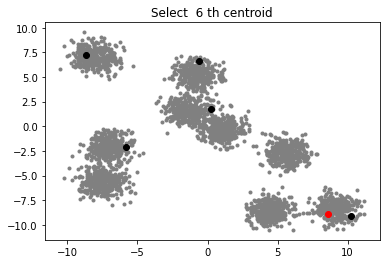

[[-5.83325875 -2.07737457]
 [-0.60896504  6.57164443]
 [-8.6908509   7.24245851]
 [10.26074638 -9.11506299]
 [ 0.23342677  1.70848921]
 [ 8.61719807 -8.92021946]
 [-6.20350898 -5.07918503]]
[-5.83325875 -0.60896504 -8.6908509  10.26074638  0.23342677  8.61719807]


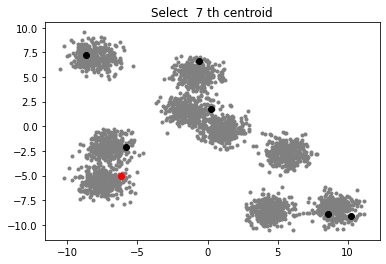

[[-5.83325875 -2.07737457]
 [-0.60896504  6.57164443]
 [-8.6908509   7.24245851]
 [10.26074638 -9.11506299]
 [ 0.23342677  1.70848921]
 [ 8.61719807 -8.92021946]
 [-6.20350898 -5.07918503]
 [ 5.60305709 -1.38696136]]
[-5.83325875 -0.60896504 -8.6908509  10.26074638  0.23342677  8.61719807
 -6.20350898]


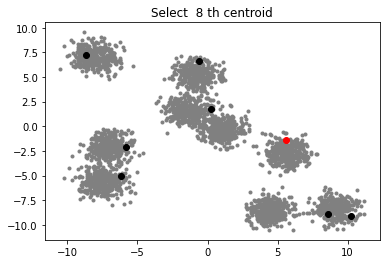

[[-5.83325875 -2.07737457]
 [-0.60896504  6.57164443]
 [-8.6908509   7.24245851]
 [10.26074638 -9.11506299]
 [ 0.23342677  1.70848921]
 [ 8.61719807 -8.92021946]
 [-6.20350898 -5.07918503]
 [ 5.60305709 -1.38696136]
 [-8.67602319 -3.08787655]]
[-5.83325875 -0.60896504 -8.6908509  10.26074638  0.23342677  8.61719807
 -6.20350898  5.60305709]


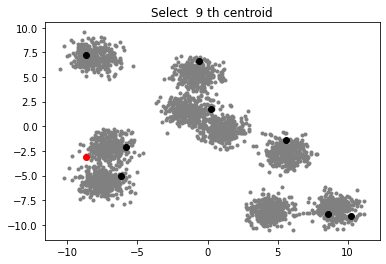

[[-7.75051147  6.13159319]
 [ 9.60608815 -8.49457252]]
[-7.75051147]


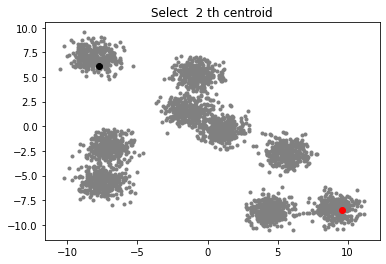

[[-7.75051147  6.13159319]
 [ 9.60608815 -8.49457252]
 [ 1.62468901 -0.39820367]]
[-7.75051147  9.60608815]


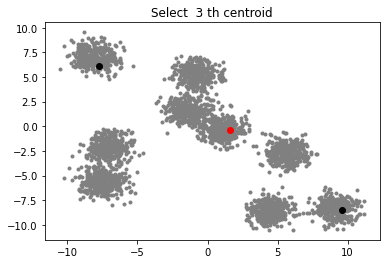

[[-7.75051147  6.13159319]
 [ 9.60608815 -8.49457252]
 [ 1.62468901 -0.39820367]
 [-7.34263777 -5.2414196 ]]
[-7.75051147  9.60608815  1.62468901]


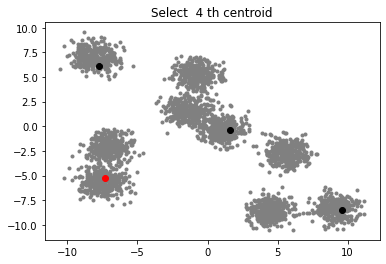

[[-7.75051147  6.13159319]
 [ 9.60608815 -8.49457252]
 [ 1.62468901 -0.39820367]
 [-7.34263777 -5.2414196 ]
 [-1.21780094  5.29938898]]
[-7.75051147  9.60608815  1.62468901 -7.34263777]


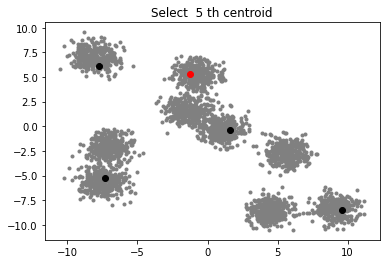

[[-7.75051147  6.13159319]
 [ 9.60608815 -8.49457252]
 [ 1.62468901 -0.39820367]
 [-7.34263777 -5.2414196 ]
 [-1.21780094  5.29938898]
 [ 5.53339226 -2.97118072]]
[-7.75051147  9.60608815  1.62468901 -7.34263777 -1.21780094]


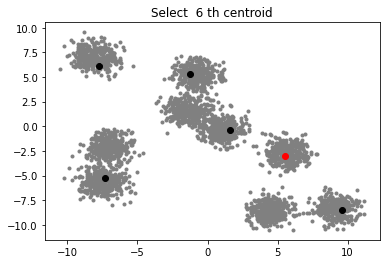

[[-7.75051147  6.13159319]
 [ 9.60608815 -8.49457252]
 [ 1.62468901 -0.39820367]
 [-7.34263777 -5.2414196 ]
 [-1.21780094  5.29938898]
 [ 5.53339226 -2.97118072]
 [-7.09402871 -0.33493561]]
[-7.75051147  9.60608815  1.62468901 -7.34263777 -1.21780094  5.53339226]


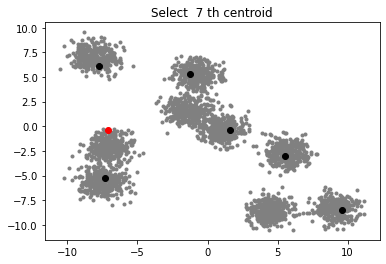

[[-7.75051147  6.13159319]
 [ 9.60608815 -8.49457252]
 [ 1.62468901 -0.39820367]
 [-7.34263777 -5.2414196 ]
 [-1.21780094  5.29938898]
 [ 5.53339226 -2.97118072]
 [-7.09402871 -0.33493561]
 [ 3.80226564 -7.52485342]]
[-7.75051147  9.60608815  1.62468901 -7.34263777 -1.21780094  5.53339226
 -7.09402871]


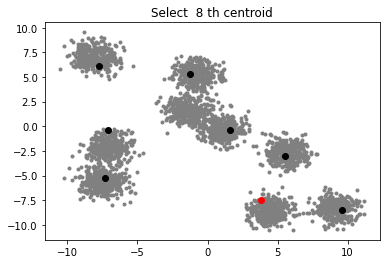

[[-7.75051147  6.13159319]
 [ 9.60608815 -8.49457252]
 [ 1.62468901 -0.39820367]
 [-7.34263777 -5.2414196 ]
 [-1.21780094  5.29938898]
 [ 5.53339226 -2.97118072]
 [-7.09402871 -0.33493561]
 [ 3.80226564 -7.52485342]
 [ 8.37846986 -6.11306392]]
[-7.75051147  9.60608815  1.62468901 -7.34263777 -1.21780094  5.53339226
 -7.09402871  3.80226564]


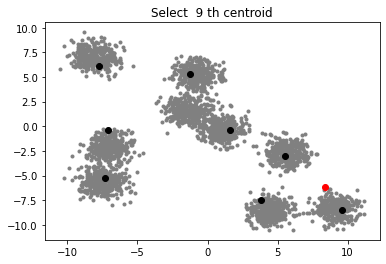

[[ 9.40049523 -8.49353746]
 [ 0.04931077  4.27509331]]
[9.40049523]


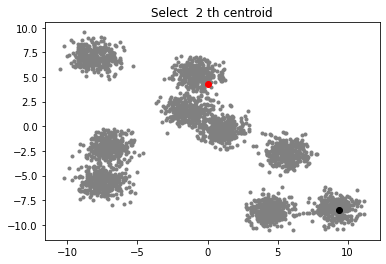

[[ 9.40049523 -8.49353746]
 [ 0.04931077  4.27509331]
 [-8.28130379 -1.244686  ]]
[9.40049523 0.04931077]


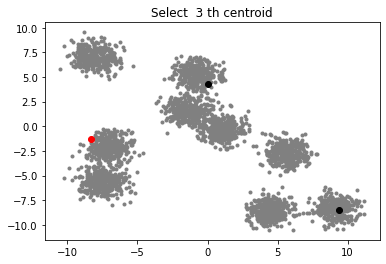

[[ 9.40049523 -8.49353746]
 [ 0.04931077  4.27509331]
 [-8.28130379 -1.244686  ]
 [ 4.11222471 -9.05148987]]
[ 9.40049523  0.04931077 -8.28130379]


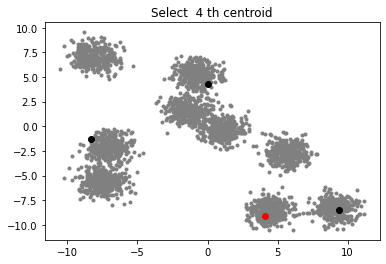

[[ 9.40049523 -8.49353746]
 [ 0.04931077  4.27509331]
 [-8.28130379 -1.244686  ]
 [ 4.11222471 -9.05148987]
 [-8.69268871  5.88610106]]
[ 9.40049523  0.04931077 -8.28130379  4.11222471]


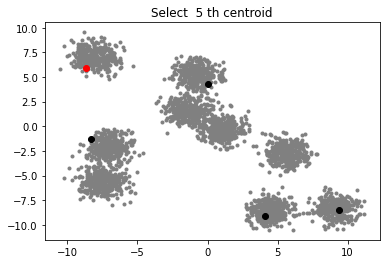

[[ 9.40049523 -8.49353746]
 [ 0.04931077  4.27509331]
 [-8.28130379 -1.244686  ]
 [ 4.11222471 -9.05148987]
 [-8.69268871  5.88610106]
 [ 4.98656647 -3.06693771]]
[ 9.40049523  0.04931077 -8.28130379  4.11222471 -8.69268871]


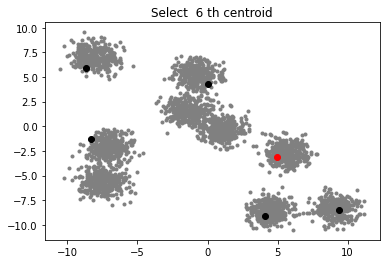

[[ 9.40049523 -8.49353746]
 [ 0.04931077  4.27509331]
 [-8.28130379 -1.244686  ]
 [ 4.11222471 -9.05148987]
 [-8.69268871  5.88610106]
 [ 4.98656647 -3.06693771]
 [ 0.30477117  1.10884721]]
[ 9.40049523  0.04931077 -8.28130379  4.11222471 -8.69268871  4.98656647]


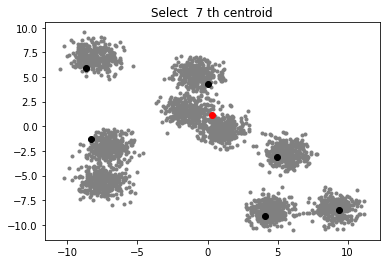

[[ 9.40049523 -8.49353746]
 [ 0.04931077  4.27509331]
 [-8.28130379 -1.244686  ]
 [ 4.11222471 -9.05148987]
 [-8.69268871  5.88610106]
 [ 4.98656647 -3.06693771]
 [ 0.30477117  1.10884721]
 [-0.54241041  5.829509  ]]
[ 9.40049523  0.04931077 -8.28130379  4.11222471 -8.69268871  4.98656647
  0.30477117]


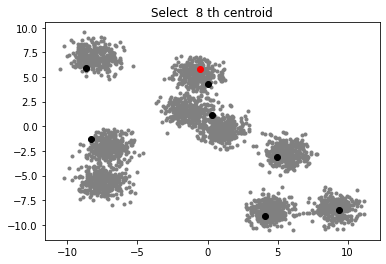

[[ 9.40049523 -8.49353746]
 [ 0.04931077  4.27509331]
 [-8.28130379 -1.244686  ]
 [ 4.11222471 -9.05148987]
 [-8.69268871  5.88610106]
 [ 4.98656647 -3.06693771]
 [ 0.30477117  1.10884721]
 [-0.54241041  5.829509  ]
 [-5.98092398 -2.2479989 ]]
[ 9.40049523  0.04931077 -8.28130379  4.11222471 -8.69268871  4.98656647
  0.30477117 -0.54241041]


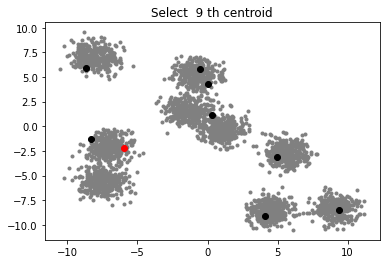

[[ 8.43174234 -7.63200983]
 [-6.67768725 -1.45732504]]
[8.43174234]


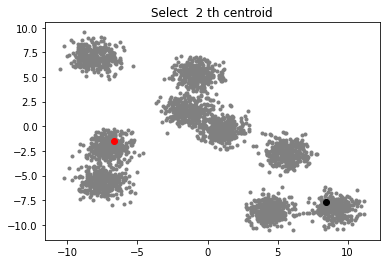

[[ 8.43174234 -7.63200983]
 [-6.67768725 -1.45732504]
 [-7.8812745   6.44431598]]
[ 8.43174234 -6.67768725]


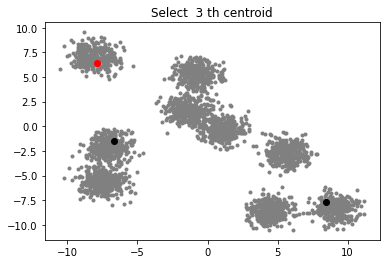

[[ 8.43174234 -7.63200983]
 [-6.67768725 -1.45732504]
 [-7.8812745   6.44431598]
 [ 0.93363935  5.48640488]]
[ 8.43174234 -6.67768725 -7.8812745 ]


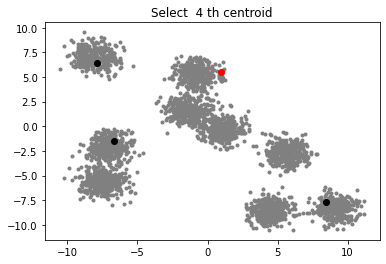

[[ 8.43174234 -7.63200983]
 [-6.67768725 -1.45732504]
 [-7.8812745   6.44431598]
 [ 0.93363935  5.48640488]
 [-0.68285685  5.41113188]]
[ 8.43174234 -6.67768725 -7.8812745   0.93363935]


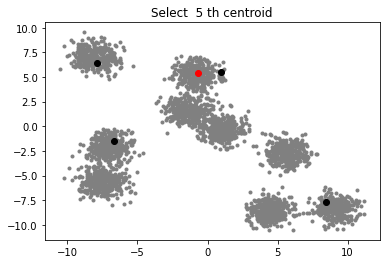

[[ 8.43174234 -7.63200983]
 [-6.67768725 -1.45732504]
 [-7.8812745   6.44431598]
 [ 0.93363935  5.48640488]
 [-0.68285685  5.41113188]
 [-1.21698724  0.29744467]]
[ 8.43174234 -6.67768725 -7.8812745   0.93363935 -0.68285685]


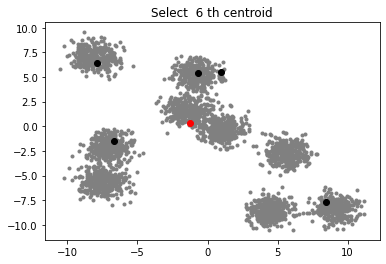

[[ 8.43174234 -7.63200983]
 [-6.67768725 -1.45732504]
 [-7.8812745   6.44431598]
 [ 0.93363935  5.48640488]
 [-0.68285685  5.41113188]
 [-1.21698724  0.29744467]
 [-6.60385938  5.302456  ]]
[ 8.43174234 -6.67768725 -7.8812745   0.93363935 -0.68285685 -1.21698724]


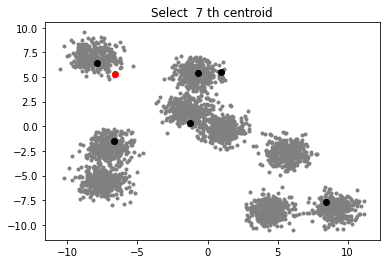

[[ 8.43174234 -7.63200983]
 [-6.67768725 -1.45732504]
 [-7.8812745   6.44431598]
 [ 0.93363935  5.48640488]
 [-0.68285685  5.41113188]
 [-1.21698724  0.29744467]
 [-6.60385938  5.302456  ]
 [ 4.07484552 -8.74556586]]
[ 8.43174234 -6.67768725 -7.8812745   0.93363935 -0.68285685 -1.21698724
 -6.60385938]


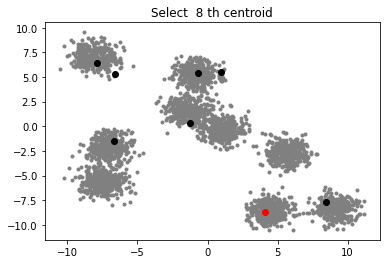

[[ 8.43174234 -7.63200983]
 [-6.67768725 -1.45732504]
 [-7.8812745   6.44431598]
 [ 0.93363935  5.48640488]
 [-0.68285685  5.41113188]
 [-1.21698724  0.29744467]
 [-6.60385938  5.302456  ]
 [ 4.07484552 -8.74556586]
 [ 6.03308624 -2.24842704]]
[ 8.43174234 -6.67768725 -7.8812745   0.93363935 -0.68285685 -1.21698724
 -6.60385938  4.07484552]


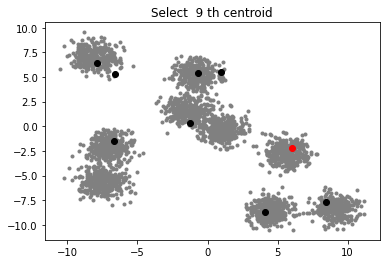

[[ 3.61182903 -8.76493118]
 [-7.83325563 -5.04601493]]
[3.61182903]


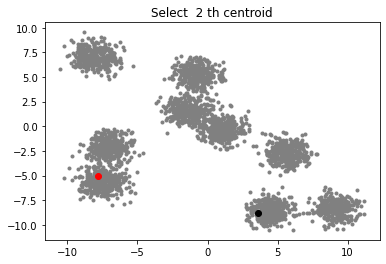

[[ 3.61182903 -8.76493118]
 [-7.83325563 -5.04601493]
 [-7.8812745   6.44431598]]
[ 3.61182903 -7.83325563]


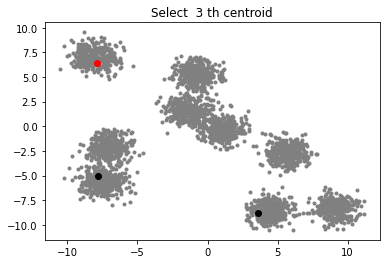

[[ 3.61182903 -8.76493118]
 [-7.83325563 -5.04601493]
 [-7.8812745   6.44431598]
 [ 5.85145011 -3.79390956]]
[ 3.61182903 -7.83325563 -7.8812745 ]


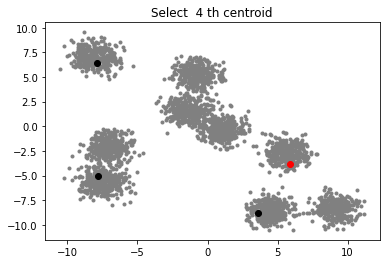

[[ 3.61182903 -8.76493118]
 [-7.83325563 -5.04601493]
 [-7.8812745   6.44431598]
 [ 5.85145011 -3.79390956]
 [-0.16829983  4.60346809]]
[ 3.61182903 -7.83325563 -7.8812745   5.85145011]


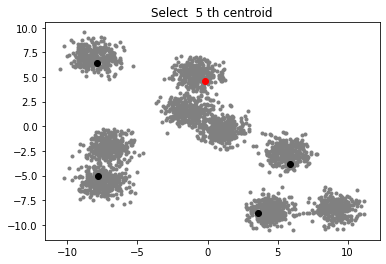

[[ 3.61182903 -8.76493118]
 [-7.83325563 -5.04601493]
 [-7.8812745   6.44431598]
 [ 5.85145011 -3.79390956]
 [-0.16829983  4.60346809]
 [-7.33332724 -1.61855457]]
[ 3.61182903 -7.83325563 -7.8812745   5.85145011 -0.16829983]


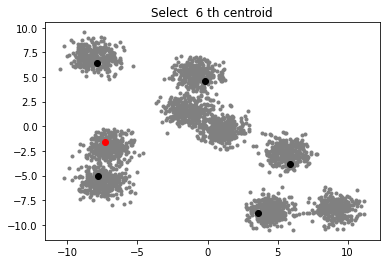

[[ 3.61182903 -8.76493118]
 [-7.83325563 -5.04601493]
 [-7.8812745   6.44431598]
 [ 5.85145011 -3.79390956]
 [-0.16829983  4.60346809]
 [-7.33332724 -1.61855457]
 [ 1.46555166 -0.01063274]]
[ 3.61182903 -7.83325563 -7.8812745   5.85145011 -0.16829983 -7.33332724]


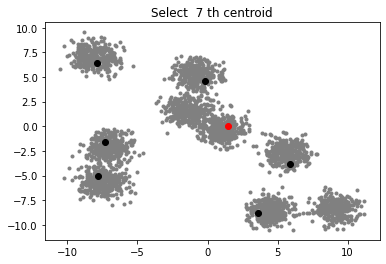

[[ 3.61182903 -8.76493118]
 [-7.83325563 -5.04601493]
 [-7.8812745   6.44431598]
 [ 5.85145011 -3.79390956]
 [-0.16829983  4.60346809]
 [-7.33332724 -1.61855457]
 [ 1.46555166 -0.01063274]
 [-7.07689764 -6.38073269]]
[ 3.61182903 -7.83325563 -7.8812745   5.85145011 -0.16829983 -7.33332724
  1.46555166]


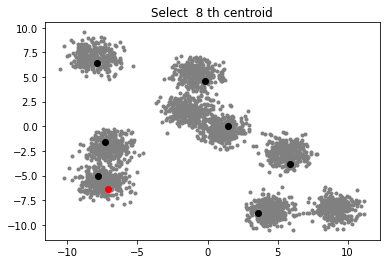

[[ 3.61182903 -8.76493118]
 [-7.83325563 -5.04601493]
 [-7.8812745   6.44431598]
 [ 5.85145011 -3.79390956]
 [-0.16829983  4.60346809]
 [-7.33332724 -1.61855457]
 [ 1.46555166 -0.01063274]
 [-7.07689764 -6.38073269]
 [-1.19148064  0.56033522]]
[ 3.61182903 -7.83325563 -7.8812745   5.85145011 -0.16829983 -7.33332724
  1.46555166 -7.07689764]


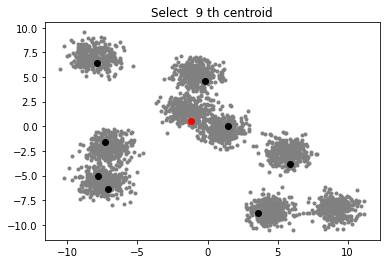

[[-8.46686142 -5.23231888]
 [-1.53317149  2.26737084]]
[-8.46686142]


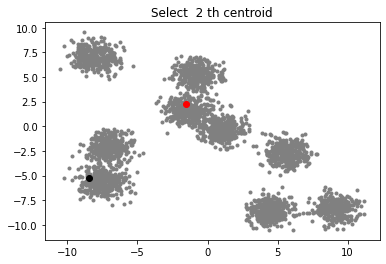

[[-8.46686142 -5.23231888]
 [-1.53317149  2.26737084]
 [ 8.09159654 -8.88071697]]
[-8.46686142 -1.53317149]


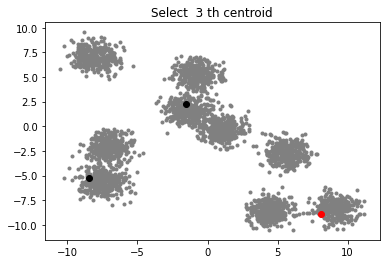

[[-8.46686142 -5.23231888]
 [-1.53317149  2.26737084]
 [ 8.09159654 -8.88071697]
 [ 4.94452565 -2.73263647]]
[-8.46686142 -1.53317149  8.09159654]


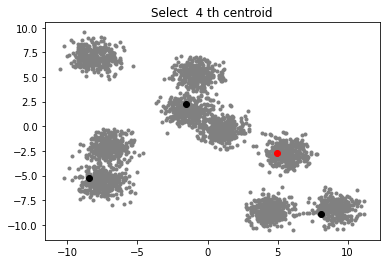

[[-8.46686142 -5.23231888]
 [-1.53317149  2.26737084]
 [ 8.09159654 -8.88071697]
 [ 4.94452565 -2.73263647]
 [-8.20002477  8.94476834]]
[-8.46686142 -1.53317149  8.09159654  4.94452565]


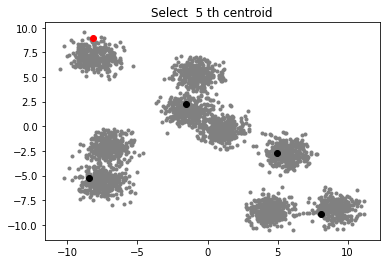

[[-8.46686142 -5.23231888]
 [-1.53317149  2.26737084]
 [ 8.09159654 -8.88071697]
 [ 4.94452565 -2.73263647]
 [-8.20002477  8.94476834]
 [ 5.40722542 -9.20442753]]
[-8.46686142 -1.53317149  8.09159654  4.94452565 -8.20002477]


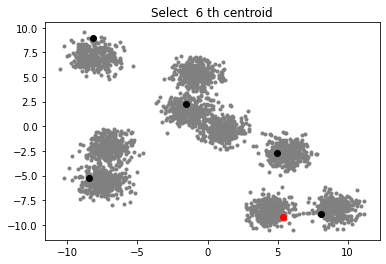

[[-8.46686142 -5.23231888]
 [-1.53317149  2.26737084]
 [ 8.09159654 -8.88071697]
 [ 4.94452565 -2.73263647]
 [-8.20002477  8.94476834]
 [ 5.40722542 -9.20442753]
 [-8.1131711  -6.25685264]]
[-8.46686142 -1.53317149  8.09159654  4.94452565 -8.20002477  5.40722542]


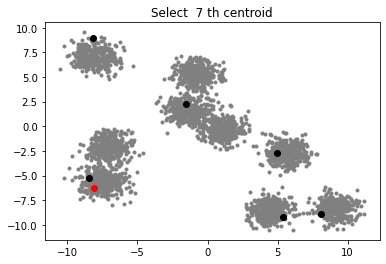

[[-8.46686142 -5.23231888]
 [-1.53317149  2.26737084]
 [ 8.09159654 -8.88071697]
 [ 4.94452565 -2.73263647]
 [-8.20002477  8.94476834]
 [ 5.40722542 -9.20442753]
 [-8.1131711  -6.25685264]
 [ 1.27883515  4.67721155]]
[-8.46686142 -1.53317149  8.09159654  4.94452565 -8.20002477  5.40722542
 -8.1131711 ]


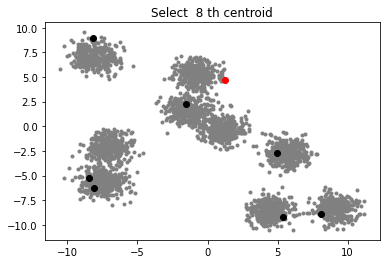

[[-8.46686142 -5.23231888]
 [-1.53317149  2.26737084]
 [ 8.09159654 -8.88071697]
 [ 4.94452565 -2.73263647]
 [-8.20002477  8.94476834]
 [ 5.40722542 -9.20442753]
 [-8.1131711  -6.25685264]
 [ 1.27883515  4.67721155]
 [-0.95420315  4.57993488]]
[-8.46686142 -1.53317149  8.09159654  4.94452565 -8.20002477  5.40722542
 -8.1131711   1.27883515]


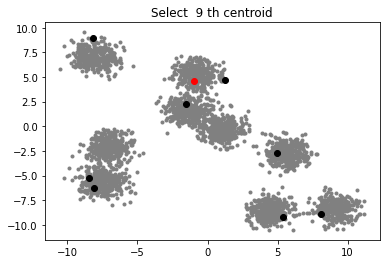

[[-8.34607552  8.73231503]
 [ 4.94452565 -2.73263647]]
[-8.34607552]


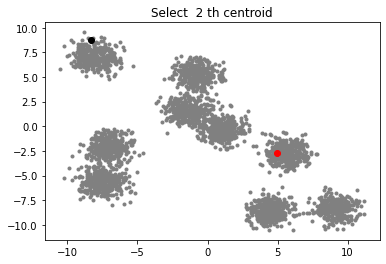

[[-8.34607552  8.73231503]
 [ 4.94452565 -2.73263647]
 [-2.87383073 -0.7118186 ]]
[-8.34607552  4.94452565]


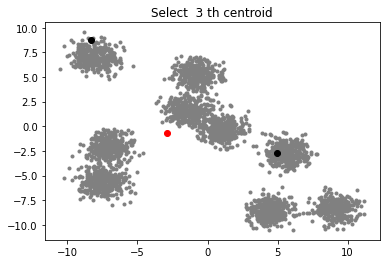

[[-8.34607552  8.73231503]
 [ 4.94452565 -2.73263647]
 [-2.87383073 -0.7118186 ]
 [ 0.04872218  5.43036071]]
[-8.34607552  4.94452565 -2.87383073]


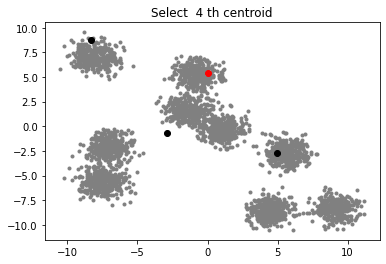

[[-8.34607552  8.73231503]
 [ 4.94452565 -2.73263647]
 [-2.87383073 -0.7118186 ]
 [ 0.04872218  5.43036071]
 [-5.40048863 -0.61809768]]
[-8.34607552  4.94452565 -2.87383073  0.04872218]


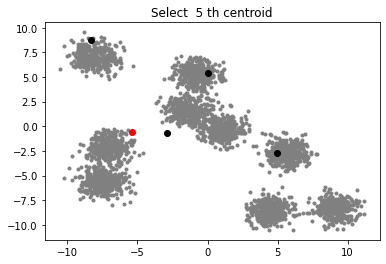

[[-8.34607552  8.73231503]
 [ 4.94452565 -2.73263647]
 [-2.87383073 -0.7118186 ]
 [ 0.04872218  5.43036071]
 [-5.40048863 -0.61809768]
 [-6.19969313 -3.83652455]]
[-8.34607552  4.94452565 -2.87383073  0.04872218 -5.40048863]


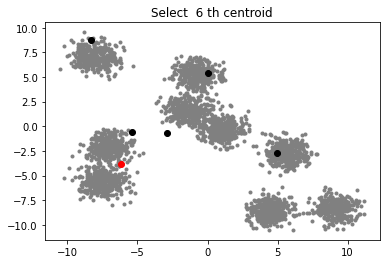

[[-8.34607552  8.73231503]
 [ 4.94452565 -2.73263647]
 [-2.87383073 -0.7118186 ]
 [ 0.04872218  5.43036071]
 [-5.40048863 -0.61809768]
 [-6.19969313 -3.83652455]
 [ 9.54853312 -9.57789139]]
[-8.34607552  4.94452565 -2.87383073  0.04872218 -5.40048863 -6.19969313]


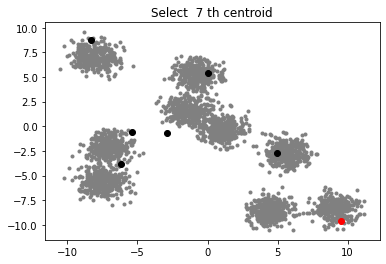

[[-8.34607552  8.73231503]
 [ 4.94452565 -2.73263647]
 [-2.87383073 -0.7118186 ]
 [ 0.04872218  5.43036071]
 [-5.40048863 -0.61809768]
 [-6.19969313 -3.83652455]
 [ 9.54853312 -9.57789139]
 [ 3.93391721 -8.28445361]]
[-8.34607552  4.94452565 -2.87383073  0.04872218 -5.40048863 -6.19969313
  9.54853312]


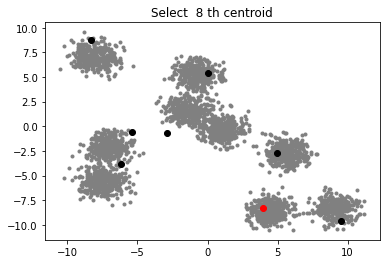

[[-8.34607552  8.73231503]
 [ 4.94452565 -2.73263647]
 [-2.87383073 -0.7118186 ]
 [ 0.04872218  5.43036071]
 [-5.40048863 -0.61809768]
 [-6.19969313 -3.83652455]
 [ 9.54853312 -9.57789139]
 [ 3.93391721 -8.28445361]
 [-1.81601108  2.41001166]]
[-8.34607552  4.94452565 -2.87383073  0.04872218 -5.40048863 -6.19969313
  9.54853312  3.93391721]


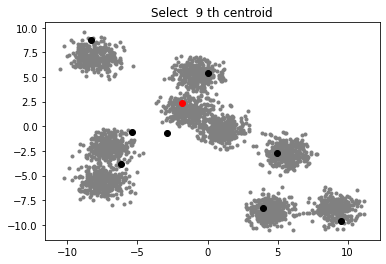

[[-2.09899812  6.5142049 ]
 [10.28018911 -7.58392032]]
[-2.09899812]


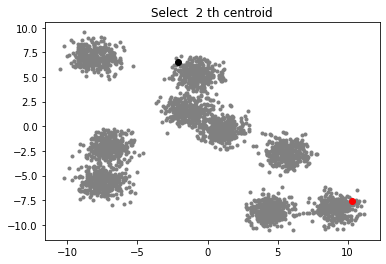

[[-2.09899812  6.5142049 ]
 [10.28018911 -7.58392032]
 [-7.73469796  6.86797   ]]
[-2.09899812 10.28018911]


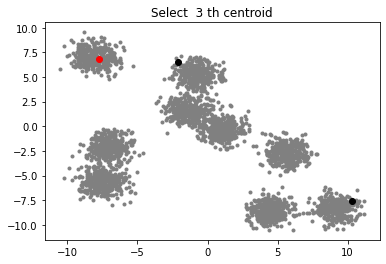

[[-2.09899812  6.5142049 ]
 [10.28018911 -7.58392032]
 [-7.73469796  6.86797   ]
 [ 1.15664042  0.24658509]]
[-2.09899812 10.28018911 -7.73469796]


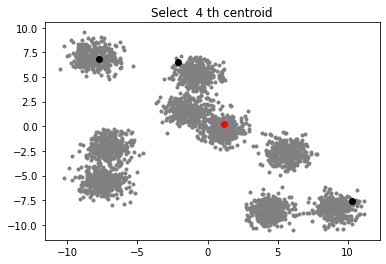

[[-2.09899812  6.5142049 ]
 [10.28018911 -7.58392032]
 [-7.73469796  6.86797   ]
 [ 1.15664042  0.24658509]
 [ 5.36859734 -0.54459777]]
[-2.09899812 10.28018911 -7.73469796  1.15664042]


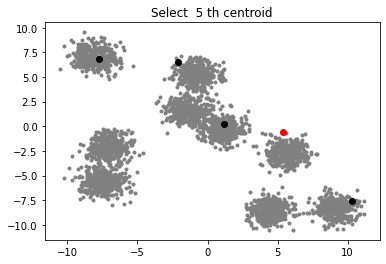

[[-2.09899812  6.5142049 ]
 [10.28018911 -7.58392032]
 [-7.73469796  6.86797   ]
 [ 1.15664042  0.24658509]
 [ 5.36859734 -0.54459777]
 [-6.88126263 -1.03252384]]
[-2.09899812 10.28018911 -7.73469796  1.15664042  5.36859734]


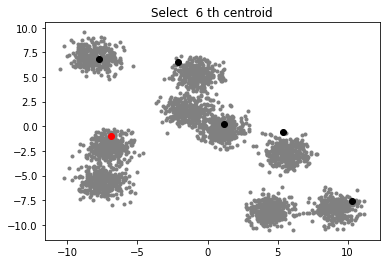

[[-2.09899812  6.5142049 ]
 [10.28018911 -7.58392032]
 [-7.73469796  6.86797   ]
 [ 1.15664042  0.24658509]
 [ 5.36859734 -0.54459777]
 [-6.88126263 -1.03252384]
 [ 2.74783914 -7.8724378 ]]
[-2.09899812 10.28018911 -7.73469796  1.15664042  5.36859734 -6.88126263]


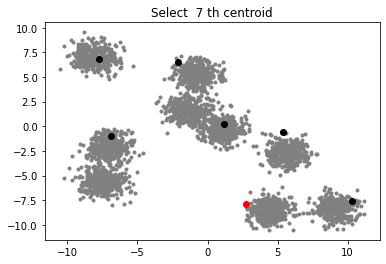

[[-2.09899812  6.5142049 ]
 [10.28018911 -7.58392032]
 [-7.73469796  6.86797   ]
 [ 1.15664042  0.24658509]
 [ 5.36859734 -0.54459777]
 [-6.88126263 -1.03252384]
 [ 2.74783914 -7.8724378 ]
 [-7.88496439 -6.74135614]]
[-2.09899812 10.28018911 -7.73469796  1.15664042  5.36859734 -6.88126263
  2.74783914]


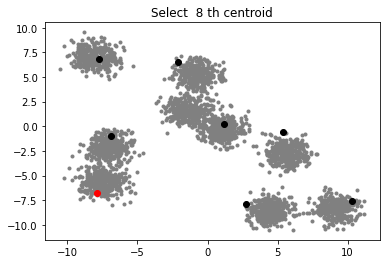

[[-2.09899812  6.5142049 ]
 [10.28018911 -7.58392032]
 [-7.73469796  6.86797   ]
 [ 1.15664042  0.24658509]
 [ 5.36859734 -0.54459777]
 [-6.88126263 -1.03252384]
 [ 2.74783914 -7.8724378 ]
 [-7.88496439 -6.74135614]
 [ 7.20467381 -3.08271999]]
[-2.09899812 10.28018911 -7.73469796  1.15664042  5.36859734 -6.88126263
  2.74783914 -7.88496439]


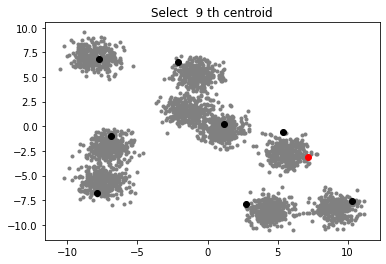

[[ 0.79327681 -1.07219457]
 [ 6.0389308  -7.79750763]]
[0.79327681]


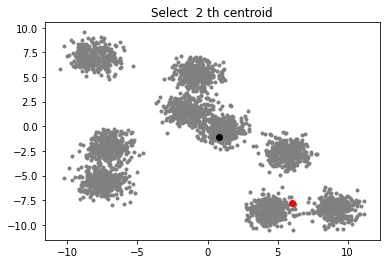

[[ 0.79327681 -1.07219457]
 [ 6.0389308  -7.79750763]
 [ 5.91027339 -3.25300843]]
[0.79327681 6.0389308 ]


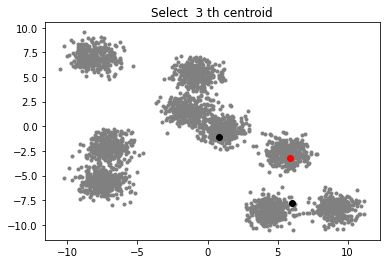

[[ 0.79327681 -1.07219457]
 [ 6.0389308  -7.79750763]
 [ 5.91027339 -3.25300843]
 [-7.74475174 -6.71189734]]
[0.79327681 6.0389308  5.91027339]


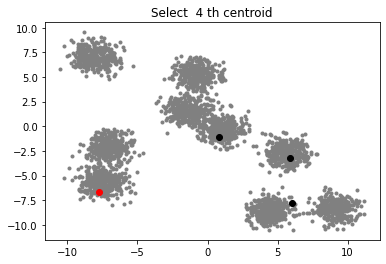

[[ 0.79327681 -1.07219457]
 [ 6.0389308  -7.79750763]
 [ 5.91027339 -3.25300843]
 [-7.74475174 -6.71189734]
 [-8.69268871  5.88610106]]
[ 0.79327681  6.0389308   5.91027339 -7.74475174]


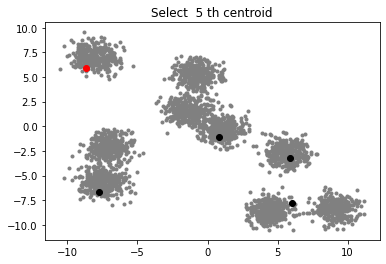

[[ 0.79327681 -1.07219457]
 [ 6.0389308  -7.79750763]
 [ 5.91027339 -3.25300843]
 [-7.74475174 -6.71189734]
 [-8.69268871  5.88610106]
 [-6.60281785 -2.61866866]]
[ 0.79327681  6.0389308   5.91027339 -7.74475174 -8.69268871]


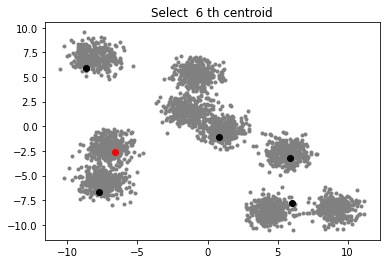

[[ 0.79327681 -1.07219457]
 [ 6.0389308  -7.79750763]
 [ 5.91027339 -3.25300843]
 [-7.74475174 -6.71189734]
 [-8.69268871  5.88610106]
 [-6.60281785 -2.61866866]
 [-0.19991881  5.65614364]]
[ 0.79327681  6.0389308   5.91027339 -7.74475174 -8.69268871 -6.60281785]


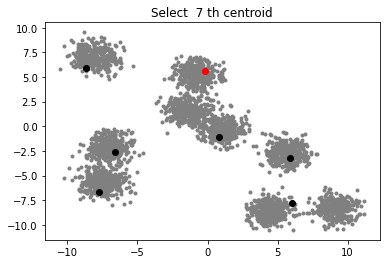

[[ 0.79327681 -1.07219457]
 [ 6.0389308  -7.79750763]
 [ 5.91027339 -3.25300843]
 [-7.74475174 -6.71189734]
 [-8.69268871  5.88610106]
 [-6.60281785 -2.61866866]
 [-0.19991881  5.65614364]
 [-1.21478873  1.87524313]]
[ 0.79327681  6.0389308   5.91027339 -7.74475174 -8.69268871 -6.60281785
 -0.19991881]


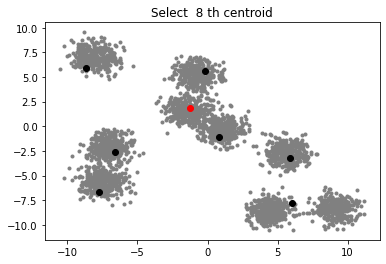

[[ 0.79327681 -1.07219457]
 [ 6.0389308  -7.79750763]
 [ 5.91027339 -3.25300843]
 [-7.74475174 -6.71189734]
 [-8.69268871  5.88610106]
 [-6.60281785 -2.61866866]
 [-0.19991881  5.65614364]
 [-1.21478873  1.87524313]
 [ 8.43610348 -7.80999582]]
[ 0.79327681  6.0389308   5.91027339 -7.74475174 -8.69268871 -6.60281785
 -0.19991881 -1.21478873]


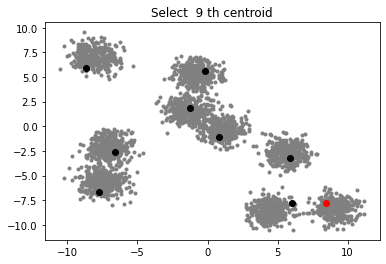

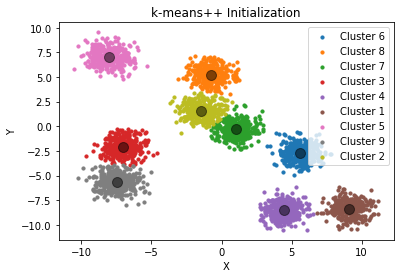

In [27]:
import matplotlib.pyplot as plt

model=k_means()
model.fit_best_model(data_X,9,10,init_method="k_means++")
# print(model.belong_centroids)
# print(model.centroids)
clusters=[]
for i in model.classifications.keys():
  clusters.append("Cluster "+str(i))  
  points=np.array(model.classifications[i])
  # print(points)
  plt.scatter(points[:,0], points[:,1],s=10)
for i,v in model.centroids.items(): 
  plt.scatter(v[0], v[1], c='black', s=100, alpha=0.5); 
plt.xlabel('X')
plt.ylabel('Y')
plt.title('k-means++ Initialization')
plt.legend(clusters)
plt.show()

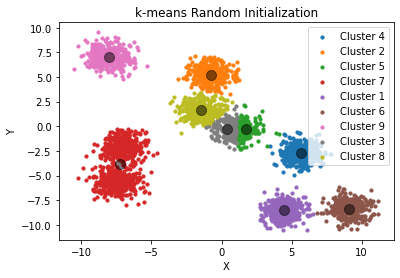

In [19]:
import matplotlib.pyplot as plt

model=k_means()
model.fit_best_model(data_X,9,10,init_method="random")
# print(model.belong_centroids)
# print(model.centroids)
clusters=[]
for i in model.classifications.keys():
  clusters.append("Cluster "+str(i))
  points=np.array(model.classifications[i])
  # print(points)
  plt.scatter(points[:,0], points[:,1],s=10)
for i,v in model.centroids.items(): 
  plt.scatter(v[0], v[1], c='black', s=100, alpha=0.5);
plt.xlabel('X')
plt.ylabel('Y')
plt.title('k-means Random Initialization')
plt.legend(clusters)
plt.show()

1
{1: array([-0.50485052, -1.52787149])}
[62.44565352363671]
2
{1: array([-3.96732984,  0.98091914]), 2: array([ 6.36842932, -6.50800811])}
[62.44565352363671, 45.52873350248633]
3
{1: array([ 6.35224686, -6.49698222]), 2: array([-2.33166225,  3.42423779]), 3: array([-7.24599437, -3.86666021])}
[62.44565352363671, 45.52873350248633, 38.57837595878427]
4
{1: array([ 6.39622284, -6.55567214]), 2: array([-8.06414959,  7.0697321 ]), 3: array([-7.24599437, -3.86666021]), 4: array([-0.36447341,  2.15113562])}
[62.44565352363671, 45.52873350248633, 38.57837595878427, 25.876659044465235]
5
{1: array([ 6.76465117, -8.43168048]), 2: array([-0.48362661,  2.30094126]), 3: array([-7.24599437, -3.86666021]), 4: array([ 5.24655729, -2.55946923]), 5: array([-8.06414959,  7.0697321 ])}
[62.44565352363671, 45.52873350248633, 38.57837595878427, 25.876659044465235, 22.43326669648589]
6
{1: array([-8.06414959,  7.0697321 ]), 2: array([ 9.09635079, -8.37293878]), 3: array([-0.48362661,  2.30094126]), 4: arr

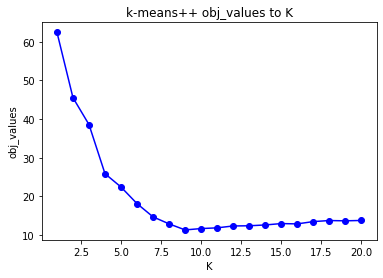

In [20]:
import matplotlib.pyplot as plt

kapas=range(1,21)
evaluations=[]
for k in kapas:
  print(k)
  # model = k_means(data=data_X,k=k,init_method="k_means++")
  model=k_means()
  # for each case of k 10 restarts are done
  model.fit_best_model(data_X,k,10,init_method="k_means++")
  #print(model.belong_centroids)
  print(model.centroids)
  # keep on list evaluations all the objective values
  evaluations.append(model.obj_function())
  print(evaluations)

# print all the evaluations and the k
plt.plot(kapas,evaluations, marker='o', color='b')
plt.xlabel('K')
plt.ylabel('obj_values')
plt.title('k-means++ obj_values to K')
plt.show()

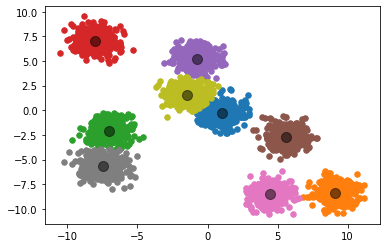

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=9)
kmeans.fit(data_X)

y_km = kmeans.fit_predict(data_X)
centers = kmeans.cluster_centers_

# plot the found clusters and their centers
for i in range(9):
  plt.scatter(data_X[y_km ==i,0], data_X[y_km == i,1], s=30)

for i in range(9): 
  plt.scatter(centers[i, 0], centers[i, 1], c='black', s=100, alpha=0.5);


In [21]:
obj_rand_list=[]
obj_k_m_list=[]
# we perform 800 runs with 1 restart to compare the performance between k-means++ and random
for i in range(800):
  if i%10==0:
    print("I:",i)
  model=k_means()
  model.fit_best_model(data_X,9,1,init_method="k_means++")
  obj_k_m_list.append(model.obj_function())
  
  model=k_means()
  model.fit_best_model(data_X,9,1,init_method="random")
  obj_rand_list.append(model.obj_function())

I: 0
I: 10
I: 20
I: 30
I: 40
I: 50
I: 60
I: 70
I: 80
I: 90
I: 100
I: 110
I: 120
I: 130
I: 140
I: 150
I: 160
I: 170
I: 180
I: 190
I: 200
I: 210
I: 220
I: 230
I: 240
I: 250
I: 260
I: 270
I: 280
I: 290
I: 300
I: 310
I: 320
I: 330
I: 340
I: 350
I: 360
I: 370
I: 380
I: 390
I: 400
I: 410
I: 420
I: 430
I: 440
I: 450
I: 460
I: 470
I: 480
I: 490
I: 500
I: 510
I: 520
I: 530
I: 540
I: 550
I: 560
I: 570
I: 580
I: 590
I: 600
I: 610
I: 620
I: 630
I: 640
I: 650
I: 660
I: 670
I: 680
I: 690
I: 700
I: 710
I: 720
I: 730
I: 740
I: 750
I: 760
I: 770
I: 780
I: 790


In [24]:
import statistics
# The mean of rands and k-means++ implementations
print(statistics.mean(obj_rand_list))
print(statistics.mean(obj_k_m_list))

# The standard deviation of rands and k-means++ implementations
print(np.std(np.array(obj_rand_list)))
print(np.std(np.array(obj_k_m_list)))

16.511996524306763
13.17725769015338
1.781969378203346
1.7893893169087467
